<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

# 1. SINDy (sparse identification of the non-linear dynamics) in Groud Truth Coordinates z

1.1 Simulation


In [2]:
# Define the pendulum_rhs function
def pendulum_rhs(z, dzdt, coefficients, terms):
    return np.dot(terms(z), coefficients)

In [3]:
# Define the pendulum_ode_step function
def pendulum_ode_step(y, t, coefficients, terms):
    D = len(y) // 2
    z_values = y[:D]
    dzdt_values = y[D:]

    # Evaluate rhs using the current terms
    rhs = pendulum_rhs(z_values, dzdt_values, coefficients, terms)

    # Check if rhs is 1-dimensional or 2-dimensional
    if np.ndim(rhs) == 1:
        dydt = np.concatenate([dzdt_values, rhs])
    else:
        dydt = np.concatenate([dzdt_values, rhs[1]])

    return dydt

In [4]:
# Function to simulate the pendulum using odeint
def simulate_pendulum(y0, coefficients, terms, T, dt):
    # Call odeint with the pendulum_ode_step function
    result = odeint(pendulum_ode_step, y0, np.arange(0, T, dt), args=(coefficients, terms))

    return result

(100, 2)
(100, 1)


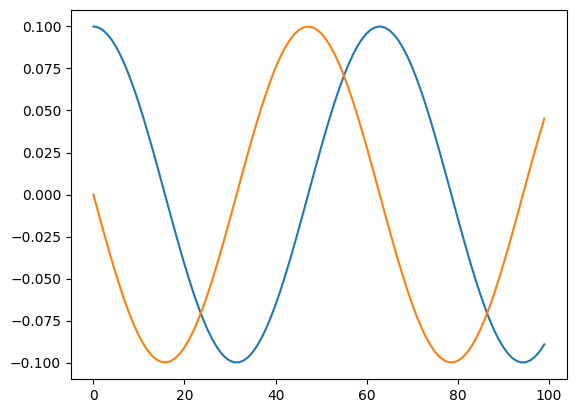

In [5]:
# checking something
D = 1
L = 1
z0 = np.array([0.1])
dz0 = np.array([0.0])
coefficients = np.array([[-1.0]])

# Define terms as a vector of functions (sine function in this case)
terms = lambda z: np.sin(z)

T = 10.0
dt = 0.1
y0 = np.concatenate([z0, dz0])

result = simulate_pendulum(y0, coefficients, terms, T, dt)
plt.plot(result); print(np.shape(result)); print(np.shape(result[:,:D]))

In [6]:
def create_pendulum_data(z0_min, z0_max,
                         dz0_min, dz0_max,
                         coefficients, terms,
                         T, dt, N,
                         embedding=None, rejection=True, Dim=1):
    data_dict = {}

    for sim_run_num in tqdm(range(N), desc="Simulations"):
        while True:
            z0 = np.array([np.random.uniform(z0_min, z0_max)])
            dz0 = np.array([np.random.uniform(dz0_min, dz0_max)])

            if not rejection:
                break  # No rejection, proceed with the simulation

            angular_momentum = 0.5 * (dz0 ** 2) - np.cos(z0)
            #print("angular_momentum", np.abs(angular_momentum))

            if np.abs(angular_momentum) <= 0.99:
                break  # Angular momentum condition satisfied, proceed with the simulation

        simulation_result = simulate_pendulum(np.concatenate([z0, dz0]), coefficients, terms, T, dt)
        # D=np.shape(simulation_result)[1]//2
        # print("Dim is:", Dim)
        second_derivative = pendulum_rhs(simulation_result[:,:Dim], simulation_result[:,Dim:],
                                         coefficients, terms)

        if embedding is not None:
            # Add code for artificial embedding (needed later)
            pass

        data_dict[sim_run_num+1]={"z":simulation_result[:, :Dim],
                                  "dzdt":simulation_result[:, Dim:],
                                  "d2zdt":second_derivative}

        #data.append((simulation_result[:, :Dim], simulation_result[:, Dim:], second_derivative))#[D:]))

    return data_dict



In [7]:
z0_min = -np.pi
z0_max = np.pi
dz0_min = -2.1
dz0_max = 2.1
coefficients = np.array([[-12.0]])
terms = lambda z: z

T = 50.0
dt = 0.02
N =  100# number of simulation runs
embedding = None
rejection = True

training_data_dict = create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max,
                                     coefficients, terms, T, dt, N, embedding, rejection)

time=np.arange(0,T,step=dt)

# print("training_data dict:")
# print(training_data_dict)

Simulations: 100%|██████████| 100/100 [00:01<00:00, 79.63it/s]


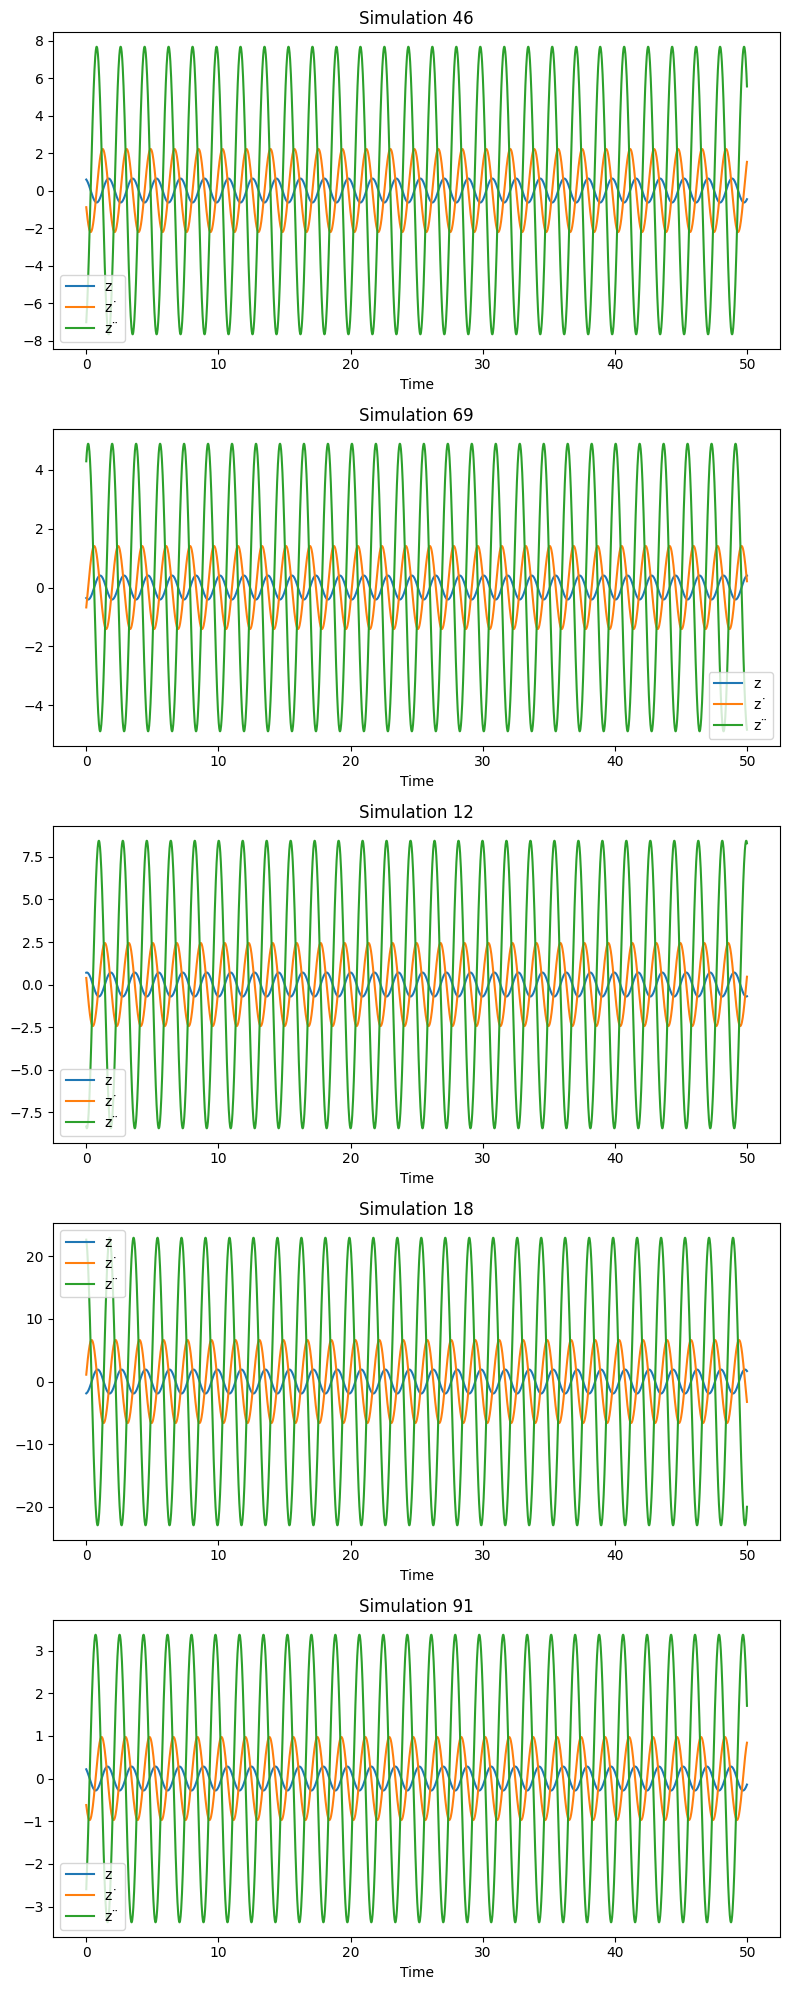

In [8]:
import matplotlib.pyplot as plt

# Choose 5 simulations randomly
selected_simulations = np.random.choice(N, 5, replace=False)

# Plot the selected simulations
fig, axs = plt.subplots(5, 1, figsize=(8, 20))

for i, sim_num in enumerate(selected_simulations):
    time_points = np.arange(0, T, step=dt)  # Assuming 'time' is not included in data_dict
    z_values = training_data_dict[sim_num+1]['z']  # zt
    dzdt_values = training_data_dict[sim_num+1]['dzdt']  # z˙t
    d2zdt_values = training_data_dict[sim_num+1]['d2zdt']  # z¨t

    # Plot z, z˙, and z¨ on the same plot
    axs[i].plot(time_points, z_values, label='z')
    axs[i].plot(time_points, dzdt_values, label='z˙')
    axs[i].plot(time_points, d2zdt_values, label='z¨')
    axs[i].set_title(f'Simulation {sim_num + 1}')
    axs[i].set_xlabel('Time')
    axs[i].legend()

plt.tight_layout()
plt.show()




Creating the training data-set

In [9]:
# Extract arrays for "z", "dzdt", and "d2zdt"
z_arrays = [v["z"] for v in training_data_dict.values()]
dzdt_arrays = [v["dzdt"] for v in training_data_dict.values()]
d2zdt_arrays = [v["d2zdt"] for v in training_data_dict.values()]

# print(z_arrays)

# Concatenate along the first axis
concatenated_z = np.concatenate(z_arrays, axis=0)
concatenated_dzdt = np.concatenate(dzdt_arrays, axis=0)
concatenated_d2zdt = np.concatenate(d2zdt_arrays, axis=0)


print("Concatenated z:")
print(concatenated_z.shape) # number of datapoints (T*N,1)

Concatenated z:
(250000, 1)


1.2 Implementation and Training

In [10]:
def sin_term(z):
    return np.sin(z)

def cos_term(z):
    return np.cos(z)

def square(z):
  return z*z

def z_times_dzdt(z,dzdt):
  return z * dzdt


def term_vector(z,dzdt):
  to_return= np.array([np.ones(np.shape(z)), z, dzdt, sin_term(z),
                   square(z), z_times_dzdt(z,dzdt),
                   z*sin_term(z), square(dzdt),
                   dzdt * sin_term(z),
                   sin_term(z)*sin_term(z)
                   ])

  return to_return

In [11]:
# Creating the X matrix for the lasso regression

flattened_z = concatenated_z.flatten()
flattened_dzdt = concatenated_dzdt.flatten()

result = term_vector(flattened_z, flattened_dzdt)
# right now our X matrix (for Lasso) is of the shape (number of features X number of datapoints)
# let transpose it so that the shape of X matrix (for lasso) is (number of datapoints X no. of features)
X_for_regression=np.transpose(result)
print("X for regression is:")
print(X_for_regression); print(X_for_regression.shape); print(concatenated_z.shape)

X for regression is:
[[ 1.         -1.55176869 -1.32668196 ...  1.76008501  1.3264418
   0.99963799]
 [ 1.         -1.57455835 -0.95137261 ...  0.90510984  0.95136588
   0.99998585]
 [ 1.         -1.58979315 -0.57149847 ...  0.3266105   0.57139535
   0.99963916]
 ...
 [ 1.         -1.39426573  1.94014321 ...  3.76415567 -1.90999124
   0.96915932]
 [ 1.         -1.35214901  2.26984487 ...  5.15219572 -2.21580384
   0.95295034]
 [ 1.         -1.30354456  2.58865563 ...  6.70113798 -2.49675912
   0.93026082]]
(250000, 10)
(250000, 1)


In [12]:
# creating training and the test set
X_train, X_test, y_train, y_test = train_test_split(X_for_regression,concatenated_d2zdt,
                                                    test_size=0.3,random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((175000, 10), (75000, 10), (175000, 1), (75000, 1))

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDataset for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Set batch size for training and test DataLoader
batch_size = 32

# Create DataLoader for training set
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for test set
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

implementing SINDy using sklearn's LASSO

In [15]:
### checking the weights using the lasso regression
from sklearn.linear_model import Lasso

# Create Lasso model
lasso = Lasso(alpha=0.001, fit_intercept=False)

# Fit the model
lasso.fit(X_train, y_train)

# Access coefficients and intercept
coefficients = lasso.coef_
# intercept = lasso.intercept_

print("Coefficients:", coefficients)
# print("Intercept:", intercept)

Coefficients: [ -0.         -11.99889597  -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.        ]


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the test set
y_pred = lasso.predict(X_test)

# Evaluate the performance using different metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 1.1135666504828716e-06
Mean Absolute Error (MAE): 0.0008043259327598551
R-squared (R2) Score: 0.999999991535458


Implementing the SINDy Regression using pytorch module

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [18]:
class SINDy(nn.Module):
    def __init__(self, input_size, output_size):
        super(SINDy, self).__init__()

        # Coefficient mask (boolean)
        self.mask = nn.Parameter(torch.ones(output_size, input_size,
                                            dtype=torch.bool), requires_grad=False)

        # Coefficient matrix
        self.coefficients = nn.Parameter(torch.ones(output_size, input_size,
                                                    dtype=torch.float32), requires_grad=True)

    def forward(self, x):
        # Apply boolean mask
        masked_coefficients = self.coefficients * self.mask.int().float()#self.mask

        # Linear combination of terms
        output = F.linear(x, masked_coefficients)

        return output

In [19]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_and_validate_sindy(model, train_loader, val_loader,
                             num_epochs=100, print_epoch=1,
                             learning_rate=0.001):
    # Define optimizer and criterion inside the function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Lists to store average epoch losses for training and validation
    avg_epoch_train_losses = []
    avg_epoch_val_losses = []

    # List to store coefficient values over time
    coefficient_values_over_time = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)

        # Log average epoch losses
        avg_epoch_train_losses.append(avg_train_loss)
        avg_epoch_val_losses.append(avg_val_loss)

        # Log coefficient values
        #print("coefficients right now:")
        coefficients_snapshot = model.coefficients.detach().clone().numpy()
        #print(coefficients_snapshot)
        coefficient_values_over_time.append(coefficients_snapshot)

        # Print average epoch losses after print_epoch number of epochs
        if epoch % print_epoch == 0:
            print(f'Epoch {epoch}/{num_epochs}, Avg. Training Loss: {avg_train_loss}, Avg. Validation Loss: {avg_val_loss}')

    return avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time


In [21]:
def plot_train_and_val_loss(train_loss, val_loss, want_logscale=True):
  plt.plot(train_loss,"-",label="train loss")
  plt.plot(val_loss, ":", label="val loss")
  plt.xlabel("epochs")
  plt.ylabel("average epoch loss")
  if want_logscale:
    plt.yscale('log')
  plt.legend()

In [22]:
# training the model
input_size = 10
output_size = 1

# Create SINDy model
sindy_model = SINDy(input_size, output_size)


# Assuming sindy_model, train_loader, and test_loader are already defined
avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time = train_and_validate_sindy(sindy_model,
                                                                                                      train_loader,
                                                                                                      test_loader,
                                                                                                      num_epochs=10,
                                                                                                      learning_rate=0.0005)


Epoch 1/10, Avg. Training Loss: 209.82396195998115, Avg. Validation Loss: 84.76422721289937
Epoch 2/10, Avg. Training Loss: 54.80337652529718, Avg. Validation Loss: 31.302840417257347
Epoch 3/10, Avg. Training Loss: 16.47272087105843, Avg. Validation Loss: 6.721213974107101
Epoch 4/10, Avg. Training Loss: 3.5528512458439763, Avg. Validation Loss: 2.4206440545643964
Epoch 5/10, Avg. Training Loss: 1.7867465508520375, Avg. Validation Loss: 1.321959723931429
Epoch 6/10, Avg. Training Loss: 0.8819202019099585, Avg. Validation Loss: 0.5596641731725007
Epoch 7/10, Avg. Training Loss: 0.31108208148881406, Avg. Validation Loss: 0.13701583912799536
Epoch 8/10, Avg. Training Loss: 0.04782326593359482, Avg. Validation Loss: 0.003525002903834227
Epoch 9/10, Avg. Training Loss: 0.00038635168010734815, Avg. Validation Loss: 1.2229451323989678e-06
Epoch 10/10, Avg. Training Loss: 2.645225267485624e-06, Avg. Validation Loss: 1.0064123510232044e-10


In [23]:
coefficient_values_over_time

[array([[-0.06869258, -1.4881873 ,  0.11066713, -1.5102726 ,  0.09547707,
          0.06312239,  0.00260529, -0.00480252,  0.04757803, -0.02150581]],
       dtype=float32),
 array([[-3.5424441e-02, -3.8831091e+00, -1.1735726e-02, -3.9293280e+00,
          4.1010085e-02,  4.6597398e-04, -3.7548117e-02,  4.9045780e-03,
         -1.0232585e-02, -3.3962768e-02]], dtype=float32),
 array([[ 1.3218578e-02, -6.0699916e+00,  2.1504493e-05, -6.0932508e+00,
          2.9436737e-02, -1.6998035e-03, -3.3148419e-02,  1.1320055e-03,
          7.1995407e-03, -1.9405363e-03]], dtype=float32),
 array([[ 6.5266546e-03, -7.5951300e+00, -3.0669281e-03, -6.7072101e+00,
          8.9008380e-03, -6.9123744e-03, -4.7210116e-02,  4.0506003e-03,
          2.4627889e-02,  1.2975920e-02]], dtype=float32),
 array([[ 9.6957129e-04, -8.7667313e+00,  1.4394120e-03, -5.0146165e+00,
          8.5661458e-03, -9.3164807e-03, -3.9220586e-02,  2.7533632e-03,
          1.8452415e-02,  4.8263177e-02]], dtype=float32),
 array(

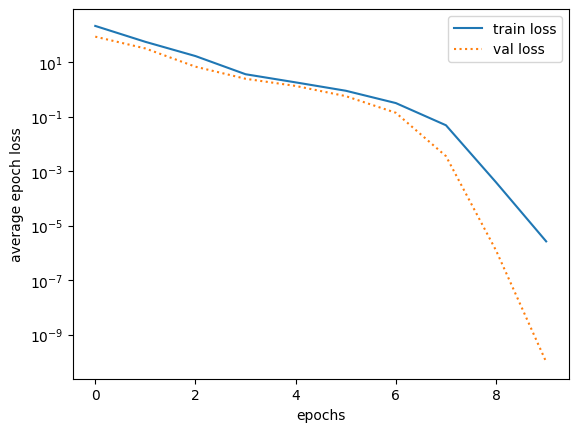

In [24]:
plot_train_and_val_loss(avg_epoch_train_losses,
                        avg_epoch_val_losses
                        )

In [25]:
# Accessing all model parameters (including coefficients)
all_parameters = list(sindy_model.parameters())

# Accessing the coefficient matrix (excluding the boolean mask)
coefficients_matrix = all_parameters[1].detach().numpy()

# Accessing the boolean mask
boolean_mask = sindy_model.mask.detach().numpy()

# Printing the results
#print("All Parameters (including coefficients):", all_parameters)
print("Coefficients:", coefficients_matrix)
print("Boolean Mask:", boolean_mask)

Coefficients: [[-1.3240002e-06 -1.1999998e+01  2.6272314e-06 -2.4312162e-06
   9.9341541e-06  8.2196885e-07 -4.9457554e-05 -2.6025305e-08
  -4.6732265e-07  5.7619261e-05]]
Boolean Mask: [[ True  True  True  True  True  True  True  True  True  True]]


1.3. Implementing the thresholding

In [26]:
def sequential_thresholding(coefficients, mask, epoch, threshold_a, interval):
    # Apply thresholding every 'interval' epochs
    # if interval > 0 and (epoch % interval == 0):
    # Identify small coefficients
    small_coefficients = torch.abs(coefficients) < threshold_a

    # Zero out small coefficients
    with torch.no_grad():
        # Zero out small coefficients
        coefficients[small_coefficients] = 0.0

    # Update the mask for coefficients smaller than a
    mask[small_coefficients] = False

    # # Set requires_grad to False for zeroed-out coefficients
    # coefficients[coefficients == 0.0].requires_grad_(False)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_and_validate_sindy(model, train_loader, val_loader,
                             num_epochs=100, print_epoch=1,
                             learning_rate=0.001, thresholding=None, threshold_a=1e-7, interval=10):

    print("interval value is:", interval)
    # Define optimizer and criterion inside the function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Lists to store average epoch losses for training and validation
    avg_epoch_train_losses = []
    avg_epoch_val_losses = []

    # List to store coefficient values over time
    coefficient_values_over_time = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)

        # Log average epoch losses
        avg_epoch_train_losses.append(avg_train_loss)
        avg_epoch_val_losses.append(avg_val_loss)

        # Apply Sequential Thresholding (ST) if specified
        if thresholding == "sequential":
            print(f"epoch % interval is: {epoch % interval}")
            if (epoch % interval == 0):
              print("now coefficients will be set to zero")
              sequential_thresholding(model.coefficients, model.mask, epoch, threshold_a, interval)

        # Log coefficient values
        print("coefficients right now:")
        coefficients_snapshot = model.coefficients.detach().clone().numpy()
        print((model.coefficients.detach().clone() * model.mask.detach().int().float()).numpy())
        print("boolean matrix:")
        print(model.mask.detach().numpy())
        coefficient_values_over_time.append(coefficients_snapshot)


        # Print average epoch losses after print_epoch number of epochs
        if epoch % print_epoch == 0:
            print(f'Epoch {epoch}/{num_epochs}, Avg. Training Loss: {avg_train_loss}, Avg. Validation Loss: {avg_val_loss}')

    return avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time

In [28]:
# training the model
input_size = 10
output_size = 1

# Create SINDy model
sindy_model_ST = SINDy(input_size, output_size)


# Assuming sindy_model, train_loader, and test_loader are already defined
avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time = train_and_validate_sindy(sindy_model_ST,
                                                                                                      train_loader,
                                                                                                      test_loader,
                                                                                                      num_epochs=10,
                                                                                                      learning_rate=0.0005,
                                                                                                      thresholding="sequential",
                                                                                                      threshold_a=0.00001,
                                                                                                      interval=2)


interval value is: 2
epoch % interval is: 1
coefficients right now:
[[-0.06331894 -1.4801178   0.10676479 -1.5056317   0.1104278   0.07531531
   0.01799386 -0.00199867  0.05124539 -0.01233137]]
boolean matrix:
[[ True  True  True  True  True  True  True  True  True  True]]
Epoch 1/10, Avg. Training Loss: 209.6819877167641, Avg. Validation Loss: 84.9630155270417
epoch % interval is: 0
now coefficients will be set to zero
coefficients right now:
[[-4.3943644e-02 -3.8733807e+00  1.1797017e-02 -3.9265764e+00
   4.4796381e-02  6.2801414e-03 -3.8457315e-02 -1.7533805e-03
  -1.1954643e-02 -4.3913942e-02]]
boolean matrix:
[[ True  True  True  True  True  True  True  True  True  True]]
Epoch 2/10, Avg. Training Loss: 55.00619972233886, Avg. Validation Loss: 31.424636941415866
epoch % interval is: 1
coefficients right now:
[[ 2.0781747e-04 -6.0631342e+00 -1.0118055e-02 -6.0924869e+00
   2.7453881e-02  3.5793753e-03 -4.0009364e-02 -1.5634298e-03
   7.0774113e-03 -1.7988171e-02]]
boolean matrix:
[

In [29]:
# Accessing all model parameters (including coefficients)
all_parameters = list(sindy_model_ST.parameters())

# Accessing the coefficient matrix (excluding the boolean mask)
coefficients_matrix = all_parameters[1].detach().numpy()

# Accessing the boolean mask
boolean_mask = sindy_model_ST.mask.detach().numpy()

# Printing the results
#print("All Parameters (including coefficients):", all_parameters)
print("Coefficients:", coefficients_matrix)
print("Boolean Mask:", boolean_mask)

Coefficients: [[ 0.0000000e+00 -1.1999996e+01  0.0000000e+00  0.0000000e+00
  -1.3505210e-05  0.0000000e+00  7.0670474e-05  0.0000000e+00
   0.0000000e+00 -7.1593844e-05]]
Boolean Mask: [[False  True False False  True False  True False False  True]]


TO DO:

1. oh now I understand, I need to mask the coefficients and then use them! oh this makes sense. I get it now.

2. Implement PTAT.

Patient Trend-Aware (PTA) Thresholding

In [30]:
# def PTA_thresholding(coefficients, mask,
#                      epoch, threshold_a, threshold_b,
#                      paitence_p, E_a, E_b, previous_coefficients):

#     # Identify small coefficients
#     coefficients_exceeding_a = torch.abs(coefficients) > threshold_a
#     coefficients_exceeding_b = torch.abs(coefficients-previous_coefficients) > threshold_b

#     # Zero out small coefficients
#     with torch.no_grad():
#         # Zero out small coefficients
#         E_a[coefficients_exceeding_a] = epoch
#         E_b[coefficients_exceeding_b] = epoch

#     e_times_identity= torch.full_like(E_a, epoch)
#     mask_tilde= torch.logical_or( ((e_times_identity-E_a) < paitence_p),
#                                     ((e_times_identity-E_b) < paitence_p)
#                                   )

#     ## update the mask for coefficients
#     mask = torch.logical_and(mask, mask_tilde)

#     ## update the previous coefficients for the next epoch
#     previous_coefficients = coefficients.copy()


#     return coefficients, mask, previous_coefficients

In [31]:
def PTA_thresholding(coefficients, mask,
                     epoch, threshold_a, threshold_b,
                     patience_p, E_a, E_b, previous_coefficients):


    print("inside function coefficients are:"); print(coefficients)
    print("inside function previous coefficients are:"); print(previous_coefficients)
    # Identify coefficients exceeding thresholds
    coefficients_exceeding_a = torch.abs(coefficients) > threshold_a
    coefficients_exceeding_b = torch.abs(coefficients - previous_coefficients) > threshold_b

    print("inside function abs(prev-now):"); print(torch.abs(coefficients - previous_coefficients))

    # Update exceeded threshold epochs
    E_a[coefficients_exceeding_a] = epoch
    E_b[coefficients_exceeding_b] = epoch
    print("E_a now inside fn:"); print(E_a)
    print("E_b now inside fn:"); print(E_b)

    # Element-wise OR to create Υ˜
    mask_tilde = ((epoch - E_a) < patience_p) | ((epoch - E_b) < patience_p)
    print("mask_tilde is:"); print(mask_tilde)

    # Update the coefficient mask
    print("old mask is:");print(mask)
    new_mask = mask & mask_tilde
    # Update the original model.mask tensor in-place
    print("new mask would have been:"); print(new_mask)

    locations_false = ~new_mask
    print("locations_false:", locations_false)
    mask[locations_false] = False
    #mask.masked_scatter_(mask_tilde, new_mask)
    print("now mask is:"); print(mask)

    # Clone the coefficients for the next epoch
    previous_coefficients = coefficients.clone().detach()# This ensures that the previous_coefficients tensor is detached from the computation graph
    return previous_coefficients

In [32]:
# def checking_sth(tensor_in):
#   tensor_in+=1

# # Create a sample tensor with a specific shape
# sample_tensor = torch.tensor([[1, 2, 3], [4, 5, 6]])
# checking_sth(sample_tensor)
# print(sample_tensor)

In [33]:
# def add_1000(coeffs):
#   with torch.no_grad():
#     coeffs += 1000 # this is doing in-place changes in the tensor

In [34]:
# class SINDy_2(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(SINDy, self).__init__()

#         # Coefficient mask (boolean)
#         self.mask = nn.Parameter(torch.ones(output_size, input_size,
#                                             dtype=torch.bool), requires_grad=False)

#         # Coefficient matrix
#         self.coefficients_before_mask = nn.Parameter(torch.ones(output_size, input_size,
#                                                     dtype=torch.float32), requires_grad=True)

#         # Coefficient after masking
#         self.coefficients_after_mask


#     def forward(self, x):
#         # Apply boolean mask
#         masked_coefficients = self.coefficients * self.mask.int().float()#self.mask

#         # Linear combination of terms
#         output = F.linear(x, masked_coefficients)

#         return output

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_and_validate_sindy(model, train_loader, val_loader,
                             num_epochs=100, print_epoch=1,
                             learning_rate=0.001, thresholding=None, threshold_a=1e-3,interval=10,
                             threshold_b=1e-4, patience_p=4):

    print("interval value is:", interval)
    # Define optimizer and criterion inside the function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Lists to store average epoch losses for training and validation
    avg_epoch_train_losses = []
    avg_epoch_val_losses = []

    # List to store coefficient values over time
    coefficient_values_over_time = []

    ### initialising some additional params if thresholding is "paitence"
    if thresholding == "patient":
      E_a= torch.zeros_like(model.coefficients)
      E_b= torch.zeros_like(model.coefficients)
      previous_coefficients = torch.zeros_like(model.coefficients)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)

        # Log average epoch losses
        avg_epoch_train_losses.append(avg_train_loss)
        avg_epoch_val_losses.append(avg_val_loss)

        # Apply Sequential Thresholding (ST) if specified
        if thresholding == "sequential":
            print(f"epoch % interval is: {epoch % interval}")
            if (epoch % interval == 0):
              print("now coefficients will be set to zero")
              sequential_thresholding(model.coefficients, model.mask, epoch, threshold_a, interval)

        if thresholding == "patient":
            print("---applying PTAT -----")
            #* self.mask.int().float()
            #add_1000(model.coefficients)
            previous_coefficients= PTA_thresholding(model.coefficients #* model.mask.int().float()
                      , model.mask,
                     epoch, threshold_a, threshold_b,
                     patience_p, E_a, E_b, previous_coefficients)

            print("-------------------outside the  PTAT function right now:-----------------")

        # print("E_a now is:"); print(E_a)
        # print("E_b now is:"); print(E_b)
        # print("previous_coefficients is:"); print(previous_coefficients)


        # Log coefficient values
        print("coefficients right now:")
        coefficients_snapshot = model.coefficients.detach().clone().numpy()
        print(coefficients_snapshot)
        print("masked coefficients:")
        print((model.coefficients.detach().clone() * model.mask.detach().int().float()).numpy())
        print("boolean matrix:")
        print(model.mask.detach().numpy())
        coefficient_values_over_time.append((model.coefficients.detach().clone() * model.mask.detach().int().float()).numpy().flatten())


        # Print average epoch losses after print_epoch number of epochs
        if epoch % print_epoch == 0:
            print(f'Epoch {epoch}/{num_epochs}, Avg. Training Loss: {avg_train_loss}, Avg. Validation Loss: {avg_val_loss}')
            print("_"*50)
    return avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time

In [36]:
# training the model
input_size = 10
output_size = 1

# Create SINDy model
sindy_model_PTAT = SINDy(input_size, output_size)


# Assuming sindy_model, train_loader, and test_loader are already defined
avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time = train_and_validate_sindy(sindy_model_PTAT,
                                                                                                      train_loader,
                                                                                                      test_loader,
                                                                                                      num_epochs=10,
                                                                                                      learning_rate=0.0005,
                                                                                                      thresholding="patient",
                                                                                                      threshold_a=0.001,
                                                                                                      threshold_b=0.0001,
                                                                                                      patience_p=2)


interval value is: 10
---applying PTAT -----
inside function coefficients are:
Parameter containing:
tensor([[-0.0506, -1.4835,  0.0977, -1.5043,  0.1122,  0.0711,  0.0267, -0.0025,
          0.0444,  0.0022]], requires_grad=True)
inside function previous coefficients are:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
inside function abs(prev-now):
tensor([[0.0506, 1.4835, 0.0977, 1.5043, 0.1122, 0.0711, 0.0267, 0.0025, 0.0444,
         0.0022]], grad_fn=<AbsBackward0>)
E_a now inside fn:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
E_b now inside fn:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
mask_tilde is:
tensor([[True, True, True, True, True, True, True, True, True, True]])
old mask is:
Parameter containing:
tensor([[True, True, True, True, True, True, True, True, True, True]])
new mask would have been:
tensor([[True, True, True, True, True, True, True, True, True, True]])
locations_false: tensor([[False, False, False, False, False, False, False, False, False, Fa

In [37]:
coefficient_values_over_time

[array([-0.05055124, -1.4835026 ,  0.09769984, -1.5042897 ,  0.11216106,
         0.07108115,  0.02666102, -0.00249628,  0.04443102,  0.0022182 ],
       dtype=float32),
 array([-2.9211333e-02, -3.8846478e+00,  5.1458729e-03, -3.9272122e+00,
         4.8855428e-02,  1.4214329e-02, -2.6625056e-02, -2.2699977e-03,
        -7.1282657e-03, -2.5588132e-02], dtype=float32),
 array([ 2.0192247e-03, -6.0665402e+00, -5.8418228e-03, -6.0919924e+00,
         2.8507261e-02,  1.2268342e-02, -3.6037028e-02,  3.5012362e-03,
         1.5465453e-02, -1.1896655e-02], dtype=float32),
 array([ 6.4565567e-03, -7.5949731e+00,  3.5412237e-03, -6.7038817e+00,
         8.2195448e-03, -1.1224310e-02, -4.7866493e-02,  1.5474794e-03,
         2.3915980e-03,  9.5461672e-03], dtype=float32),
 array([ 2.0868196e-03, -8.7488384e+00,  8.9445931e-04, -5.0291967e+00,
         4.0857736e-03, -1.3186715e-02, -4.6387821e-02, -3.4547091e-04,
         1.1892343e-02,  3.6817588e-02], dtype=float32),
 array([ 4.7734194e-04, -9

In [38]:
coefficient_array= np.array(coefficient_values_over_time)

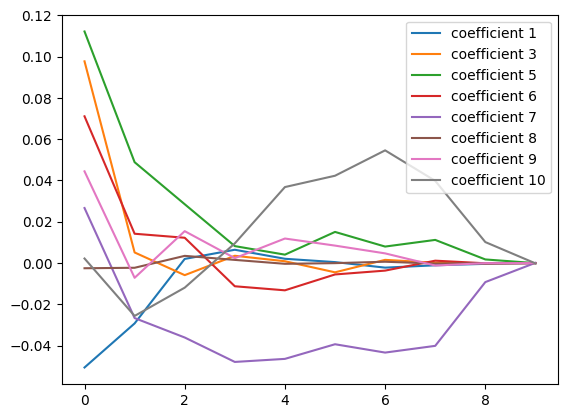

In [44]:
for i in range(0,10):
  if i!=1 and i!=3:
    plt.plot(coefficient_array[:,i], label=f"coefficient {i+1}")
plt.legend()

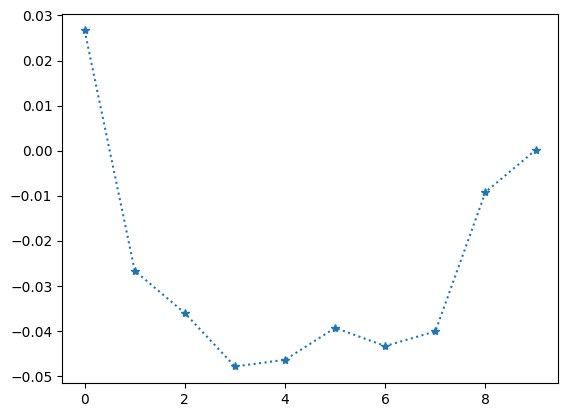

In [40]:
plt.plot(coefficient_array[:,6],"*:")

In [41]:
# threshold_a=1e-3,interval=10,
#                              threshold_b=1e-4, patience_p=4

# Everything below is not important

In [42]:
# import numpy as np
# from scipy.integrate import odeint
# import matplotlib.pyplot as plt

# # Define the ODE system
# def my_ode(y, t):
#     dydt = -2 * y  # Example: simple exponential decay
#     return dydt

# # Initial condition
# y0 = 1.0

# # Time points
# t = np.linspace(0, 5, 101)

# # Solve the ODE using odeint
# solution = odeint(my_ode, y0, t)

# # Plot the solution
# plt.plot(t, solution)
# plt.xlabel('Time')
# plt.ylabel('y(t)')
# plt.title('ODE Solution')
# plt.show()
